In [1]:
!pip install -U -q wandb

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression

import wandb
from wandb.keras import WandbCallback

# Config TPU

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# WandB Login

Thanks to [Tensor girl](https://www.kaggle.com/usharengaraju) for her useful notebooks with W&B

![wandb](https://i.imgur.com/gb6B4ig.png)

In [4]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api_key")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Load Data

In [5]:
%%time
train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv').set_index("Id")
test = pd.read_csv('../input/tabular-playground-series-dec-2021/test.csv').set_index("Id")
sample_submission = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")

feature_cols = test.columns.tolist()
cnt_cols = [col for col in feature_cols if (not col.startswith("Soil_Type")) and (not col.startswith("Wilderness_Area"))]
bin_cols = [col for col in feature_cols if col not in cnt_cols]

CPU times: user 17.8 s, sys: 6.22 s, total: 24 s
Wall time: 28.9 s


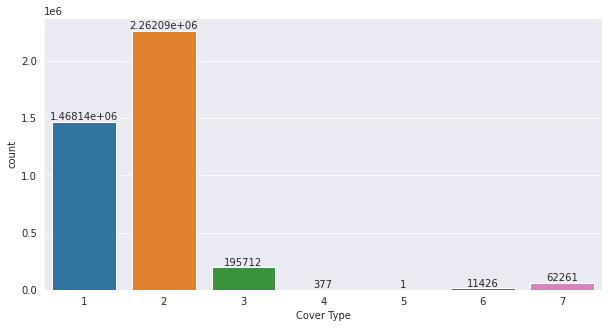

In [6]:
plt.figure(figsize=(10,5))
axs = sns.countplot(x="Cover_Type", data=train)
plt.xlabel("Cover Type")
axs.bar_label(axs.containers[0])
plt.show()

In [7]:
train = train.append([train[train["Cover_Type"]==5]]*100, ignore_index=True) #Resampling Class 5
train["Cover_Type"] = train["Cover_Type"] - 1

# Reduce Memory Usage

In [8]:
for col in feature_cols:
    if col in cnt_cols:
        train[col] = train[col].astype("float32")
        test[col] = test[col].astype("float32")
    else:
        train[col] = train[col].astype("bool")
        test[col] = test[col].astype("bool")

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,4000100.0,2975.279541,288.764038,1773.0,2760.0,2966.0,3217.0,4383.0
Aspect,4000100.0,151.515747,109.801651,-33.0,60.0,123.0,247.0,407.0
Slope,4000100.0,15.096612,8.532907,-3.0,9.0,14.0,20.0,64.0
Horizontal_Distance_To_Hydrology,4000100.0,271.723236,226.040848,-92.0,110.0,213.0,361.0,1602.0
Vertical_Distance_To_Hydrology,4000100.0,51.632236,68.105324,-317.0,4.0,31.0,78.0,647.0
Horizontal_Distance_To_Roadways,4000100.0,1766.331787,1313.260254,-287.0,822.0,1436.0,2365.0,7666.0
Hillshade_9am,4000100.0,212.571960,30.710855,-4.0,198.0,218.0,233.0,301.0
Hillshade_Noon,4000100.0,221.899216,22.230209,49.0,210.0,224.0,237.0,279.0
Hillshade_3pm,4000100.0,140.798035,43.630402,-53.0,115.0,142.0,169.0,272.0
Horizontal_Distance_To_Fire_Points,4000100.0,1581.433105,1126.011719,-277.0,781.0,1361.0,2084.0,8075.0


# Add More Features

Thanks to [@lucamassaron](https://www.kaggle.com/lucamassaron) for [this discussion](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/291839).

In [10]:
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

train['Aspect2'] = train.Aspect.map(r)
test['Aspect2'] = test.Aspect.map(r)

In [11]:
train['Highwater'] = train.Vertical_Distance_To_Hydrology < 0
test['Highwater'] = test.Vertical_Distance_To_Hydrology < 0

train['DistHydro'] = train.Horizontal_Distance_To_Hydrology < 0
test['DistHydro'] = test.Horizontal_Distance_To_Hydrology < 0

train['DistRoad'] = train.Horizontal_Distance_To_Roadways < 0
test['DistRoad'] = test.Horizontal_Distance_To_Roadways < 0

train['DistFire'] = train.Horizontal_Distance_To_Fire_Points < 0
test['DistFire'] = test.Horizontal_Distance_To_Fire_Points < 0

train['Hillshade_3pm_is_zero'] = train.Hillshade_3pm == 0
test['Hillshade_3pm_is_zero'] = test.Hillshade_3pm == 0

In [12]:
train['EHiElv'] = train['Horizontal_Distance_To_Roadways'] * train['Elevation']
test['EHiElv'] = test['Horizontal_Distance_To_Roadways'] * test['Elevation']

train['EViElv'] = train['Vertical_Distance_To_Hydrology'] * train['Elevation']
test['EViElv'] = test['Vertical_Distance_To_Hydrology'] * test['Elevation']

In [13]:
train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

In [14]:
train['Distanse_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

In [15]:
train["new_f1"] = train["Elevation"] + train["Horizontal_Distance_To_Roadways"] + train["Horizontal_Distance_To_Fire_Points"]
test["new_f1"] = test["Elevation"] + test["Horizontal_Distance_To_Roadways"] + test["Horizontal_Distance_To_Fire_Points"]

train["new_f2"] = (train["Hillshade_Noon"] + train["Hillshade_3pm"]) - train["Hillshade_9am"]
test["new_f2"] = (test["Hillshade_Noon"] + test["Hillshade_3pm"]) - test["Hillshade_9am"]

In [16]:
feature_cols += ["new_f1", "new_f2", "Aspect2", "Highwater", "EVDtH", "EHDtH",  'EHiElv', 'EViElv', 'Hillshade_3pm_is_zero',
                 "Distanse_to_Hydrolody", "Hydro_Fire_1", "Hydro_Fire_2", "Hydro_Road_1", "Hydro_Road_2", "Fire_Road_1", "Fire_Road_2"]
cnt_cols += ["new_f1", "new_f2", "Aspect2", "EVDtH", "EHDtH", 'EHiElv', 'EViElv', 
                 "Distanse_to_Hydrolody", "Hydro_Fire_1", "Hydro_Fire_2", "Hydro_Road_1", "Hydro_Road_2", "Fire_Road_1", "Fire_Road_2"]
bin_cols += ["Highwater", 'Hillshade_3pm_is_zero']

# Mutual Information

In [17]:
%%time
x = train.iloc[:5000,:][feature_cols].copy()
y = train.iloc[:5000,:]['Cover_Type'].copy()
mi_scores = mutual_info_regression(x, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

CPU times: user 7.99 s, sys: 33.3 ms, total: 8.02 s
Wall time: 8.02 s


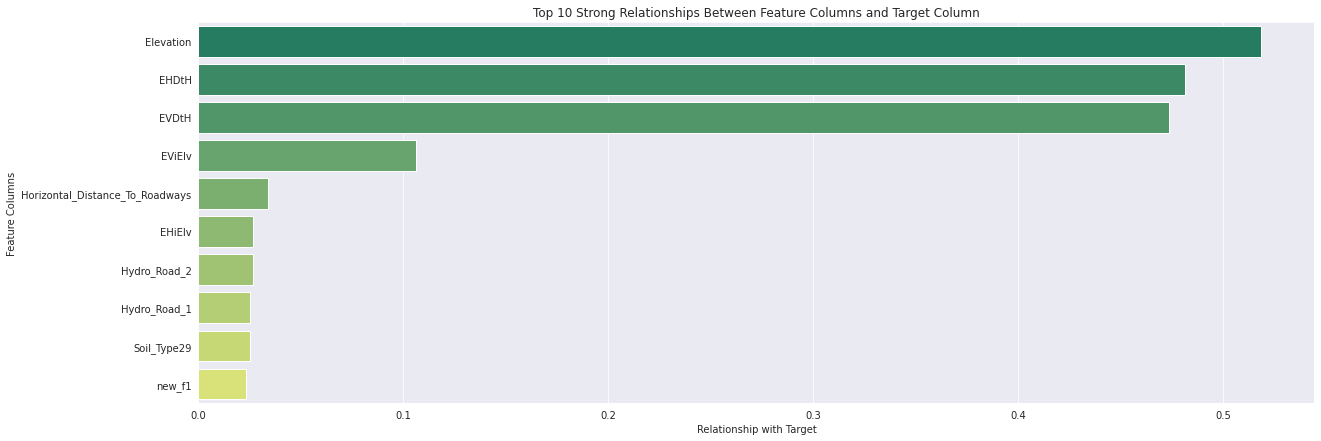

In [18]:
top = 10
plt.figure(figsize=(20,7))
fig = sns.barplot(x=mi_scores.values[:top], y=mi_scores.index[:top], palette="summer")
plt.title(f"Top {top} Strong Relationships Between Feature Columns and Target Column")
plt.xlabel("Relationship with Target")
plt.ylabel("Feature Columns")
plt.savefig("mi_scores.png")
plt.show()

# Scale Data

In [19]:
sc = RobustScaler()
train[cnt_cols] = sc.fit_transform(train[cnt_cols]).astype(np.float32)
test[cnt_cols] = sc.transform(test[cnt_cols]).astype(np.float32)

# Neural Network Model

In [20]:
x_cnt = train[cnt_cols].values
x_bin = train[bin_cols].values
y  = train['Cover_Type'].values

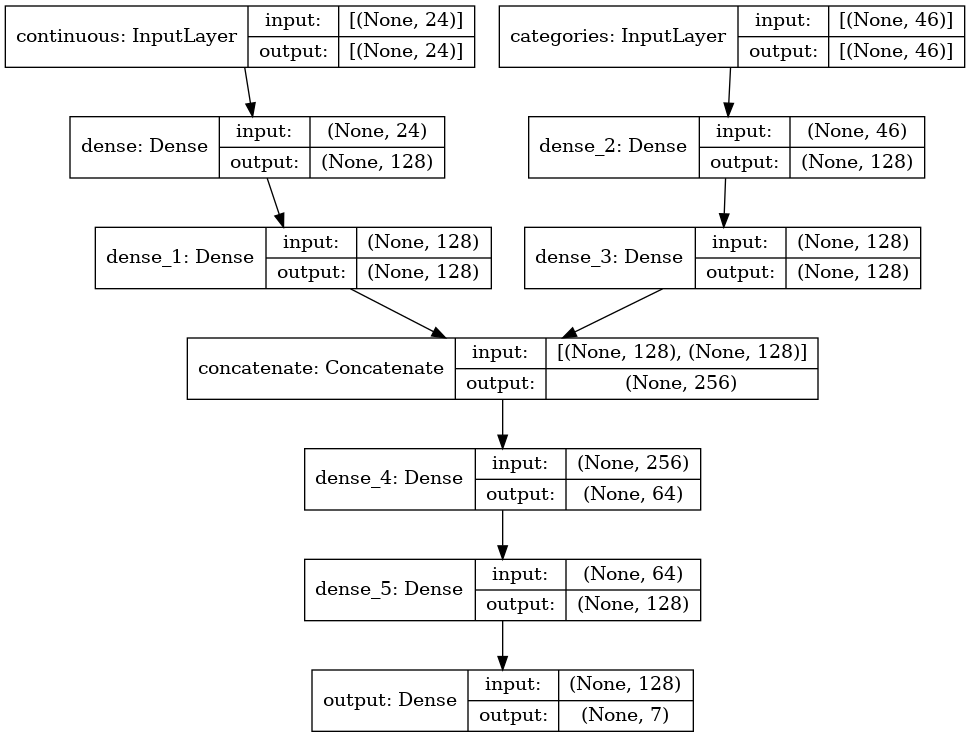

In [21]:
def get_model():
    AF = "swish"
    input_1 = layers.Input(shape=(x_cnt.shape[-1]), name="continuous")
    x_1 = layers.Dense(128, activation=AF)(input_1)
    x_1 = layers.Dense(128, activation=AF)(x_1)
    
    input_2 = layers.Input(shape=x_bin.shape[-1], name="categories")
    x_2 = layers.Dense(128, activation=AF)(input_2)
    x_2 = layers.Dense(128, activation=AF)(x_2)

    x = layers.Concatenate()([x_1,x_2])
    x = layers.Dense(64, activation=AF)(x)
    x = layers.Dense(128, activation=AF)(x)
    output = layers.Dense(7, activation="softmax", name="output")(x)

    model = tf.keras.Model([input_1,input_2], output)
    return model

with strategy.scope():
    model = get_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
    
tf.keras.utils.plot_model(model, show_shapes=True)

## WandB Log

In [22]:
run = wandb.init(project="TPS_Dec", name="training_log", entity="kaveh", anonymous=anony)

wandb.config = {
  "learning_rate": 0.001,
  "epochs": 40,
  "batch_size": 4096,
  "competition": "TPS Dec",
  "Notebook": "TPS Dec 2021 - TensorFlow NN (TPU) and W&B"
}

wandb.log({"MI scores of features": wandb.Image("./mi_scores.png")})
wandb.log({"Model Architecture": wandb.Image("./model.png")})

wandb: Currently logged in as: kaveh (use `wandb login --relogin` to force relogin)


In [23]:
cb_wb = WandbCallback()
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, mode="max", min_lr=0.0001, verbose=1)

history = model.fit((x_cnt, x_bin), 
                    y, 
                    epochs=40, 
                    validation_split=0.2, 
                    batch_size=4096, 
                    validation_batch_size=4096,
                    callbacks=[cb_es, cb_lr, cb_wb])

Epoch 1/40
782/782 [==============================] - 20s 20ms/step - loss: 0.3726 - accuracy: 0.8898 - val_loss: 0.1364 - val_accuracy: 0.9465
Epoch 2/40
782/782 [==============================] - 13s 16ms/step - loss: 0.1075 - accuracy: 0.9542 - val_loss: 0.1197 - val_accuracy: 0.9515
Epoch 3/40
782/782 [==============================] - 12s 16ms/step - loss: 0.0969 - accuracy: 0.9576 - val_loss: 0.1126 - val_accuracy: 0.9532
Epoch 4/40
782/782 [==============================] - 13s 17ms/step - loss: 0.0930 - accuracy: 0.9583 - val_loss: 0.1068 - val_accuracy: 0.9546
Epoch 5/40
782/782 [==============================] - 13s 17ms/step - loss: 0.0899 - accuracy: 0.9593 - val_loss: 0.1040 - val_accuracy: 0.9555
Epoch 6/40
782/782 [==============================] - 13s 17ms/step - loss: 0.0877 - accuracy: 0.9599 - val_loss: 0.1034 - val_accuracy: 0.9557
Epoch 7/40
782/782 [==============================] - 13s 17ms/step - loss: 0.0860 - accuracy: 0.9604 - val_loss: 0.0999 - val_accuracy:

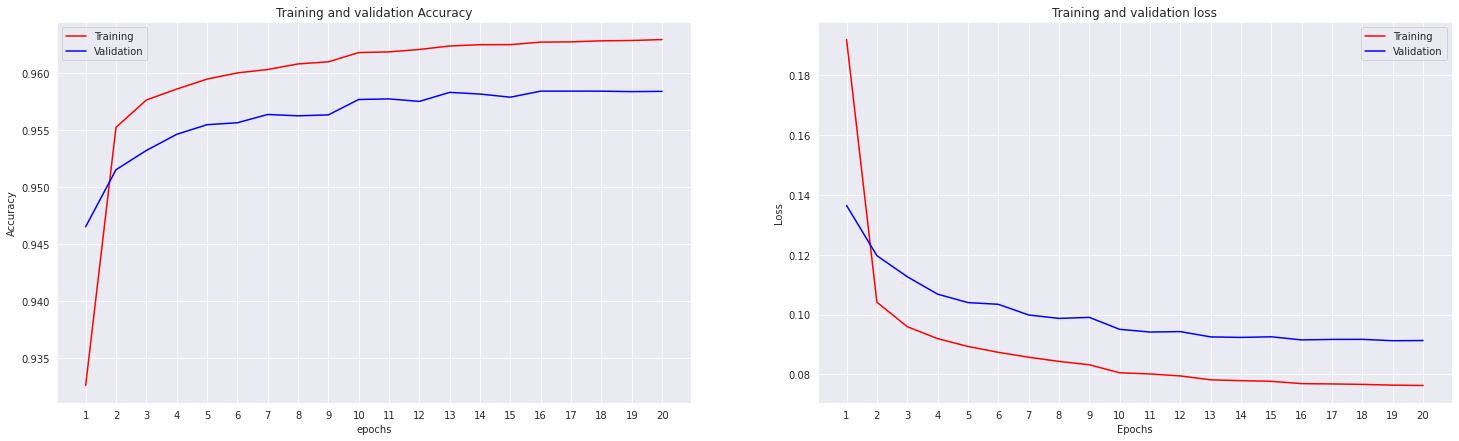

In [24]:
plt.figure(figsize=(25,7))
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1) 
ax1 = plt.subplot(1,2,1)
ax1.plot(epochs, acc, 'r')
ax1.plot(epochs, val_acc, 'b')
ax1.set_xticks([i for i in epochs])
ax1.set_title('Training and validation Accuracy')
ax1.legend(["Training", "Validation" ])
ax1.set_xlabel("epochs")
ax1.set_ylabel("Accuracy")

ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, loss, 'r')
ax2.plot(epochs, val_loss, 'b')
ax2.set_xticks([i for i in epochs])
ax2.legend(["Training", "Validation" ])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title('Training and validation loss')

plt.show()

# Predict

In [25]:
preds = model.predict((test[cnt_cols].values, test[bin_cols].values))
p = np.argmax(preds, axis=1) + 1

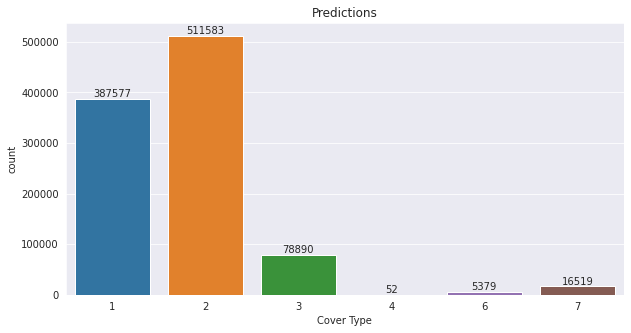

In [26]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x=p)
plt.title("Predictions")
plt.xlabel("Cover Type")
ax.bar_label(ax.containers[0])
plt.savefig("predictions.png")
plt.show()

In [27]:
wandb.log({"Predictions Stats": wandb.Image("./predictions.png")})
wandb.finish()

accuracy,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████▄▄▄▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇██▇████████
val_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.96297
best_epoch,18
best_val_loss,0.09126
epoch,19
loss,0.07632


# Submission

In [28]:
sample_submission['Cover_Type'] = p
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
